<a href="https://colab.research.google.com/github/abhay43/ML_Code/blob/master/DL-GAN%20Network%20in%20Face%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from zipfile import ZipFile

In [3]:
file_name = '/content/drive/My Drive/Faltu/28577_36420_compressed_fer2013.csv.zip'
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')

File Name                                             Modified             Size
fer2013.csv                                    2019-10-01 04:15:22    301072766
Extracting all the files now...
Done!


In [4]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
import os
import cv2
import numpy as np


In [6]:
import pandas as pd
data = pd.read_csv('/content/fer2013.csv')

In [7]:
len(data['pixels'])

35887

In [8]:
pixels = list()
for index,row in data.iterrows():
  pixels.append(list(map(int, (row['pixels'].split(' ')))) )



In [9]:
images_train = np.array(pixels).reshape(len(pixels), 2304)

In [10]:
images_train.shape

(35887, 2304)

In [11]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow.keras as kr
import tensorflow as tf
import imageio

In [12]:
epochs = 100
batchsize = 20
training_samples = 100
test_samples = 100
train_data_dir=r"/content/training"
test_data_dir=r"/content/test"
img_weight, img_height =48, 48 
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim =  48

In [13]:
import tensorflow.keras.backend as k
if k.image_data_format()=='channels_first': 
    layer_input=(3, img_weight, img_height)
else:
    layer_input=(img_weight,img_height,3)

In [14]:
def build_generator():
  gf = 48
  channels = 3
  def conv2d(layer_input, filters=16, strides=1, name=None, f_size=4):
      d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', name=name)(layer_input)
      #d = InstanceNormalization(name=name+"_bn")(d)
      d = Activation('relu')(d)
      return d
    
  def residual(layer_input, filters=16, strides=1, name=None, f_size=3):
      d = conv2d(layer_input, filters=filters, strides=strides, name=name, f_size=f_size)
      d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', name=name+"_2")(d)
      #d = InstanceNormalization(name=name+"_bn2")(d)
      d = kr.layers.add([d, layer_input])
      return d

  def conv2d_transpose(layer_input, filters=16, strides=1, name=None, f_size=4):
      u = Conv2DTranspose(filters, strides=strides, name=name, kernel_size=f_size, padding='same')(layer_input)
      #u = InstanceNormalization(name=name+"_bn")(u)
      u = Activation('relu')(u)
      return u

  # Image input
  c0 = Input(shape=layer_input)
  c1 = conv2d(c0, filters=gf, strides=1, name="g_e1", f_size=7)
  c2 = conv2d(c1, filters=gf*2, strides=2, name="g_e2", f_size=3)
  c3 = conv2d(c2, filters=gf*4, strides=2, name="g_e3", f_size=3)

  r1 = residual(c3, filters=gf*4, name='g_r1')
  r2 = residual(r1, gf*4, name='g_r2')
  r3 = residual(r2, gf*4, name='g_r3')
  r4 = residual(r3, gf*4, name='g_r4')
  r5 = residual(r4, gf*4, name='g_r5')
  r6 = residual(r5, gf*4, name='g_r6')
  r7 = residual(r6, gf*4, name='g_r7')
  r8 = residual(r7, gf*4, name='g_r8')
  r9 = residual(r8, gf*4, name='g_r9')

  d1 = conv2d_transpose(r9, filters=gf*2, f_size=3, strides=2, name='g_d1_dc')
  d2 = conv2d_transpose(d1, filters=gf, f_size=3, strides=2, name='g_d2_dc')

  output_img = Conv2D(channels, kernel_size=7, strides=1, padding='same', activation='tanh')(d2)

  return Model(inputs=[c0], outputs=[output_img])

In [15]:
model_gen = build_generator()
model_gen.compile(loss='binary_crossentropy', optimizer=adam)

In [16]:
model_gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
g_e1 (Conv2D)                   (None, 48, 48, 48)   7104        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 48)   0           g_e1[0][0]                       
__________________________________________________________________________________________________
g_e2 (Conv2D)                   (None, 24, 24, 96)   41568       activation[0][0]                 
______________________________________________________________________________________________

In [17]:
def build_discriminator():
    df = 48
    def d_layer(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        #if normalization:
        #    d = InstanceNormalization()(d)
        return d

    img = Input(shape= layer_input)

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

In [18]:
model_dis = build_discriminator()

In [19]:
model_dis.compile(loss='binary_crossentropy', optimizer=adam)

In [20]:
model_dis.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 48)        2352      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 96)        73824     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 192)         295104    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 192)         0   

In [21]:
model_dis.trainable = False
ganInput = Input(shape=(layer_input)) #100
x = model_gen(ganInput)  #784 G(z)
ganOutput = model_dis(x) #1
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [22]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
model (Model)                (None, 48, 48, 3)         6404739   
_________________________________________________________________
model_1 (Model)              (None, 3, 3, 1)           1557457   
Total params: 7,962,196
Trainable params: 6,404,739
Non-trainable params: 1,557,457
_________________________________________________________________


In [50]:
def plotGeneratedImages(epoch,batchSize, examples=100, dim=(10, 10), figsize=(10, 10)):
  noise = np.random.rand(48 * 48 * 3 * batchSize)            
  noise = -1 + noise * 2
  noise = noise.reshape((batchSize, 48, 48, 3))
  generatedImages = model_gen.predict(noise)
  generatedImages = generatedImages.reshape(batchSize, 48, 48, 3)
  print('Plotting')
  plt.figure(figsize=figsize)
  for i in range(generatedImages.shape[0]):
      plt.subplot(dim[0], dim[1], i+1)
      plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
  plt.tight_layout()
  plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [51]:
def train(epochs=1, batchSize=128):
    batchCount = int(images_train.shape[0] / batchSize) #60000/128
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)
    ss =1
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        
        for _ in range(batchCount): #358
                        
            print('batch running-'+str(ss))
            ss = ss+1
            # Get a random set of input noise and images
            noise = np.random.rand(48 * 48 * 3 * batchSize)            
            noise = -1 + noise * 2
            noise = noise.reshape((batchSize, 48, 48, 3))
            #img = imageio.imread('/img.png', as_gray=False, pilmode="RGB").astype(np.float)
            #noise = img + 3 * img.std() * np.random.random(img.shape)
           # noise = np.random.normal(0, 1, size=(128, 3)) #generating z 128*100            
            imageBatch = images_train[np.random.randint(0, images_train.shape[0], size=(batchSize, 3))] #128*784            
            imageBatch = imageBatch.reshape((batchSize, 48, 48,3 ))            
            # Generate fake fashion MNIST images
            generatedImages = model_gen.predict(noise) #128*784            
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages]) #256*784
            
            # Labels for generated and real data
            yDis = np.zeros(shape=(batchSize *2, 1,1,1))  #256 size array of all zeros
            # One-sided label smoothing
            yDis[:batchSize] = 0.9  #making real images label = 0.9
            
            # Train discriminator
            model_dis.trainable = True
            dloss = model_dis.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.rand(48 * 48 * 3 * batchSize)            
            noise = -1 + noise * 2
            noise = noise.reshape((batchSize, 48, 48, 3))
            yGen = np.ones(shape=(batchSize , 1,1,1)) #labels it as one
            model_dis.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        

        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e,batchSize,batchSize)

Epochs: 1
Batch size: 500
Batches per epoch: 71
--------------- Epoch 1 ---------------
batch running-1
batch running-2
batch running-3
batch running-4
batch running-5
batch running-6
batch running-7
batch running-8
batch running-9
batch running-10
batch running-11
batch running-12
batch running-13
batch running-14
batch running-15
batch running-16
batch running-17
batch running-18
batch running-19
batch running-20
batch running-21
batch running-22
batch running-23
batch running-24
batch running-25
batch running-26
batch running-27
batch running-28
batch running-29
batch running-30
batch running-31
batch running-32
batch running-33
batch running-34
batch running-35
batch running-36
batch running-37
batch running-38
batch running-39
batch running-40
batch running-41
batch running-42
batch running-43
batch running-44
batch running-45
batch running-46
batch running-47
batch running-48
batch running-49
batch running-50
batch running-51
batch running-52
batch running-53
batch running-54
bat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plotting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ValueError: ignored

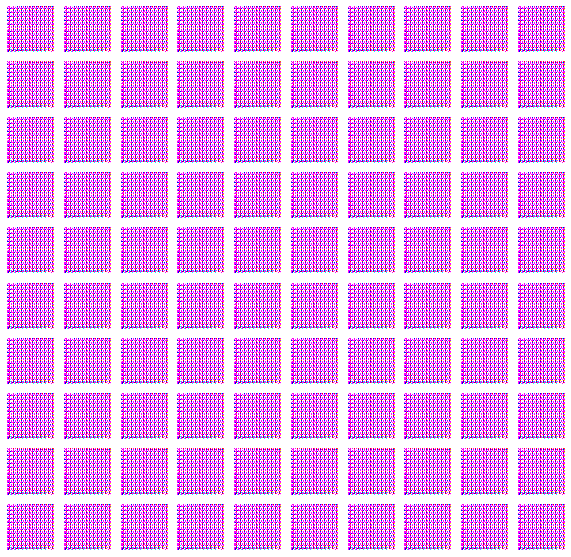

In [52]:
train(1,500)